# Fill in outs 
## June

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os


from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'


## We don't know now many outs there are at any point!

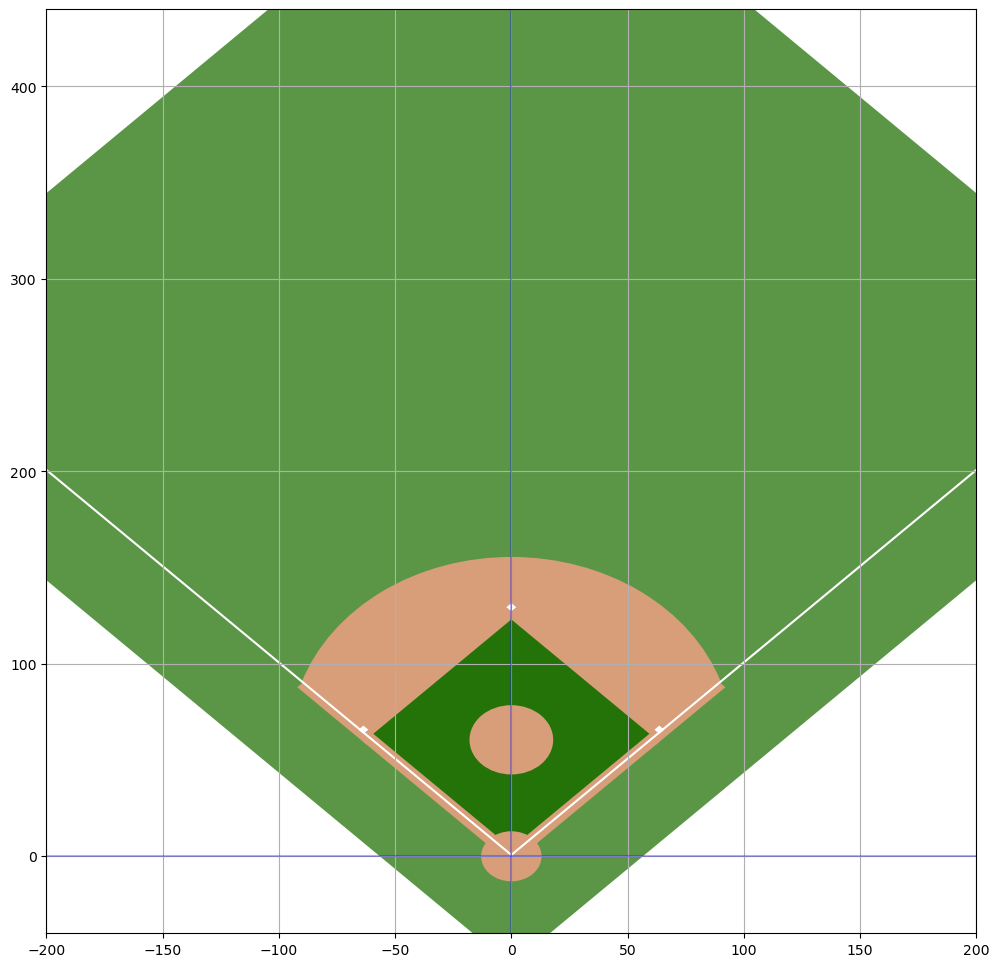

In [3]:
bf_1903_30 = Baseball_Field("1903_30_TeamNB_TeamA1")

In [4]:
first_two_innings = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"].isin([1, 2])), :].copy()

first_two_innings["prev_outs"] = np.nan
first_two_innings["this_play_outs"] = np.nan


first_two_innings["n_br"] = first_two_innings[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)


# the number of outs but be the same as before
hr_indices = bf_1903_30.game_obj.game_events_df["event"] == "home run"


# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = first_two_innings.loc[first_two_innings["top_bottom_inning"].shift() != first_two_innings["top_bottom_inning"]].index

first_two_innings.loc[switiching_sides_indices, "prev_outs"] = 0



In [5]:
hr_indices = bf_1903_30.game_obj.game_events_df["event"] == "home run"



In [6]:
# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = first_two_innings.loc[first_two_innings["top_bottom_inning"].shift() != first_two_innings["top_bottom_inning"]].index


first_two_innings.loc[switiching_sides_indices, "prev_outs"] = 0


In [7]:
first_two_innings.loc[12:30, :]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
12,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,12,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,NaN,0
13,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,13,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
14,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,14,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
15,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,15,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
16,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,16,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
17,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,17,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
18,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,18,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,NaN,NaN,1
19,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,19,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,NaN,NaN,1
20,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,20,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,NaN,NaN,1
21,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,21,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,2919,0,NaN,NaN,1


## Lean full into the Sudoku solver strategy


At a high level, I think I need:
- a recursive function that returns true or false
    - a for loop from 0, 2 (inclusive)
- a thing that finds an empty cell
- an "is_valid_outs" function where I enumerate all of my rules


### I think I want to keep the half inning df, but pass around the sequences!

In [27]:
def solve_outs_sequence_seq(half_inning_df, seq):
    
    empty_cell_index = find_empty_cell_seq(seq)
    
    if empty_cell_index is None:
        # you have found a valid solution and this is what makes your thing return
        return True
    
    
    for this_play_outs in range(3):
        
        # print("print looking at ", this_play_outs)

        
        if is_valid_outs_assignment_seq(half_inning_df, seq, this_play_outs, empty_cell_index):
            seq[empty_cell_index, 1] = this_play_outs
            
            temp_sum = 0 if empty_cell_index == 0 else sum(seq[empty_cell_index - 1, :])
            
            seq[empty_cell_index, 0] = temp_sum
            
            pass
            
           # half_inning_df.loc[empty_cell_index, "this_play_outs"] = this_play_outs
           # half_inning_df.loc[empty_cell_index, "prev_outs"] = half_inning_df.loc[empty_cell_index - 1, ["this_play_outs", "prev_outs"]].sum()
            
            
            if solve_outs_sequence_seq(half_inning_df, seq):
                # you did it!
                return True
        
            seq[empty_cell_index, 0] = np.nan
            seq[empty_cell_index, 1] = np.nan
            
    return False


def find_empty_cell_seq(seq):
    
    #seq = half_inning_df["this_play_outs"] 
    
    index = None
    
    # this play outs is in the second column!
    
    for i, val in enumerate(seq[:, 1]):
        if np.isnan(val):
            return i
    
    return index


def is_valid_outs_assignment_seq(half_inning_df, seq, this_play_outs, empty_cell_index):
    
    all_batting_team = ["batter", "first_baserunner", "second_baserunner", "third_baserunner"]
    all_br = ["first_baserunner", "second_baserunner", "third_baserunner"]
    
    seq_len = seq.shape[0]
    
    # debugging
    
    this_row = half_inning_df.iloc[empty_cell_index]
    
    old_set_batting_team = set()
    prev_total_outs = 0
    
    if empty_cell_index != 0:
        # you need to set and check all of the things that look at the prev row 
        old_set_batting_team = set(half_inning_df.iloc[empty_cell_index - 1][all_batting_team])
        prev_total_outs = sum(seq[empty_cell_index - 1, :])
          
    next_batter = None
    next_set_batting_team = set()
    next_set_br = set()
    next_second_br = None
    next_third_br = None
    


    if empty_cell_index < seq_len - 1:
        next_batter = half_inning_df.iloc[empty_cell_index + 1]["batter"]
        next_set_batting_team = set(half_inning_df.iloc[empty_cell_index + 1][all_batting_team])
        next_set_br = set(half_inning_df.iloc[empty_cell_index + 1][all_br])
        
        next_second_br = half_inning_df.iloc[empty_cell_index + 1]["second_baserunner"]
        next_third_br = half_inning_df.iloc[empty_cell_index + 1]["third_baserunner"]
    
    this_batter = half_inning_df.iloc[empty_cell_index]["batter"]
    this_set_br = set(half_inning_df.iloc[empty_cell_index][all_br])
    this_first_br = half_inning_df.iloc[empty_cell_index]["first_baserunner"]
    this_second_br = half_inning_df.iloc[empty_cell_index]["second_baserunner"]
    this_third_br = half_inning_df.iloc[empty_cell_index]["third_baserunner"]
    
    
    
    same_batter_next_play = this_batter == next_batter
    
    # Outs has to be the same or more as all previous indices in the sequence
    this_set_batting_team = set(half_inning_df.iloc[empty_cell_index][all_batting_team])
        
    
    does_this_make_3 = prev_total_outs + this_play_outs
    
    this_play_per_game = half_inning_df.iloc[empty_cell_index]["play_per_game"]
    
    hr_play_per_games = bf_1903_30.game_obj.game_events_df.loc[hr_indices, "play_per_game"].values
    
    ## end debugging
    
    pass
    
    # Assuming consecutive indices!

    
    # TODO: 
    # It can't be an out if the batter is on base next play and a runner scores
    


    if this_play_outs != 0 and this_play_per_game \
        in hr_play_per_games:
        # Outs can't go up on a home run
        return False

    if this_play_outs == 0 and this_batter not in next_set_br \
        and this_batter != next_batter and this_play_per_game not in hr_play_per_games:
        # if the batter is not on the bases when there is a new batter and it wasn't a HR then the batter got out:
    
        return False
    
    
    
    if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_first_br not in next_set_br and this_first_br != 0 and \
            ((this_second_br in next_set_br and this_second_br != 0) or (this_third_br in next_set_br and this_third_br != 0)):
        # Outs must go up if there is a runner this isn't on the bases on the next play, and there are were runners ahead of them on this play
        
        # Fielders choice out at second
        
        return False
     
        
    
    """
     if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_second_br not in next_set_br  and this_third_br in next_set_br and this_third_br != "0"):
        
        # Fielders choice out at third
        
        return False
    """

         
         
         
    # Fielders choice out at home


        

    
    
    # TODO:
    # It can't be more than one out if an outfielder catches the ball and doesn't throw it?
    
    
        
    if this_play_outs != 1 and set([br for br in this_set_br if br != 0 ]) == set([br for br in next_set_br if br != 0 ]) \
        and this_batter != next_batter:
        # TODO:
        # It must be 1 out if there are non zero BRs that stay the same, and there is a new batter -- this is a strikeout
        # Assumption this goes wrong for mid at bat PH, but that might be rare -- ignore that
        
        return False
    
    
    if this_play_outs != 0 and this_set_batting_team == next_set_batting_team:
    # Outs can't go up is there is the same batter and baserunners
        return False
    
    
    if this_play_outs > (1 + half_inning_df.iloc[empty_cell_index]["n_br"]):
        # Outs can't go up by more than the number of baserunners + 1
        return False
    
    if this_play_outs != 0 \
        and next_set_br == this_set_batting_team:
        # and half_inning_df.iloc[empty_cell_index - 1]["batter"] != 0\ # not sure about this part
        
            # Outs can't go up if the batter becomes the baserunner on the next play 
            # and the previous set of baserunners is still there

            return False
    
    
    if this_play_outs != 0 and len(this_set_batting_team) == 2 and same_batter_next_play:
        # Outs can't go up if there are no baserunners and the batter is the same in the next play
        # len(this_set_batting_team) == 2 is because the set will be batter_num and 0
    
        return False
        
    
    
    if ((seq_len - 1) == (empty_cell_index)) \
        and (does_this_make_3 != 3):
        # if we are on the last index, then this_play_outs and prev_outs must sum to three
        
        return False

    
    
    
    return True



    
    

#### Test case on an obviously 1-2-3 inning

In [9]:
first_half = first_two_innings.loc[(first_two_innings["inning"] == 1) & (first_two_innings["top_bottom_inning"] == "Top") , :]

outs_seq = first_half[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(first_half, outs_seq)

print(outs_seq)

[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [10]:
first_half.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq

In [11]:
first_half

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
1,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,1,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
2,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,2,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
3,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,3,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,1.0,0
4,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,4,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
5,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,5,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
6,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,6,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
7,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,7,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,1.0,0
8,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,8,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,0.0,0
9,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,9,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,0.0,0
10,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,10,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,0.0,0


### Bottom of the first
#### this one seems harder, because there are baserunners, etc

- if something is wrong on this, I think the plan will be to check things like throws and balls acquired, etc


In [12]:
bottom_first = first_two_innings.loc[(first_two_innings["inning"] == 1) & (first_two_innings["top_bottom_inning"] == "Bottom") , :]

outs_seq = bottom_first[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(bottom_first, outs_seq)

print(outs_seq)


[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [13]:
bottom_first.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_first


,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
12,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,12,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
13,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,13,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
14,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,14,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
15,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,15,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
16,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,16,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
17,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,17,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
18,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,18,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,0.0,0.0,1
19,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,19,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,0.0,0.0,1
20,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,20,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,0.0,0.0,1
21,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,21,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,2919,0,0.0,0.0,1


##### Description of bottom of the first

Brainstorming on how where this is wrong, and what could be done to make it work better
- I think "baserunner scores" could be something?

A description of what is going on rn:

- 20 is an advancement on a passed ball or wild pitch
- 22 is a single that moves the runner to single I think -- its actually a fielding error lol
- 27 is another advancement on a passed ball or wild pitch
- 29 is this an RBI ground out that gets called safe?

- 34 is a single to right, with the runner on third scoring
- 39 is a walk or right?
- 43 is another walk? it was wayyyy outside lol
- 46 should have been a strikeout I think? --- COME UP WITH A STRIKEOUT RULE? Maybe if there is a new batter, and all the br stay the same -- this goes wrong for mid at bat PH, but that might be rare -- 
- 51 is a walk that gets marked a strikeout -- FIX HERE -- It can't be an out if that batter it on base next play
- 56 is a flyout to center field, -- FIX HERE -- it is only one out! 

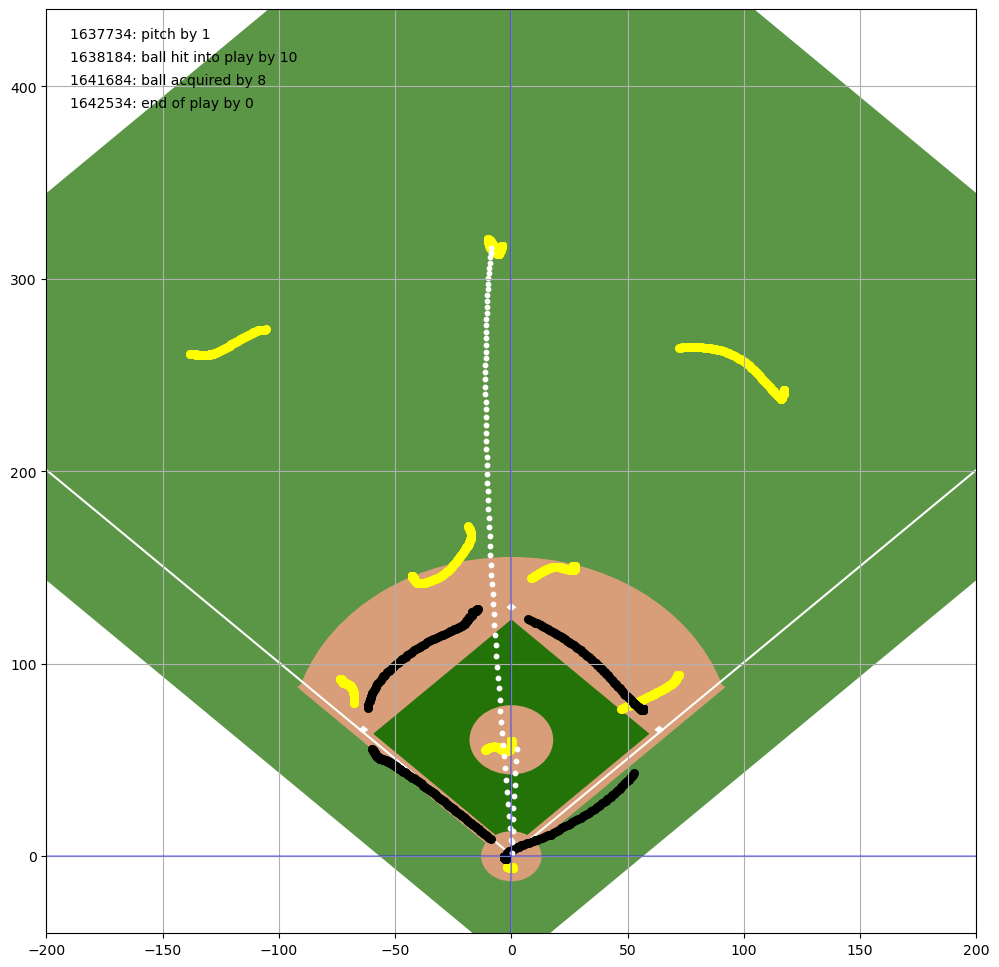

In [14]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(56)

bf_1903_30.plot_all_components(play_id=play_id)

bf_1903_30.fig
# bf_1903_30.create_gif(play_id=play_id, tag="--is this a dp")

### Top of the second

In [15]:

top_second = first_two_innings.loc[(first_two_innings["inning"] == 2) & (first_two_innings["top_bottom_inning"] == "Top") , :]

outs_seq = top_second[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(top_second, outs_seq)

print(outs_seq)


[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [16]:
top_second.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_second

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
57,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,57,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
58,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,58,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
59,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,59,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
60,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,60,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
61,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,61,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
62,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,62,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,1.0,0
63,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,63,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,1.0,0.0,0
64,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,64,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,1.0,0.0,0
65,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,65,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,1.0,1.0,0
66,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,16,66,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,0,0,0,2.0,0.0,0


##### Top of second description

A description of what is going on rn:

- 62 was a 4-3 put out
- 65 is a 6-3 put out
- 69 is a dropped third strike lol
- 75 is 6 unassisted

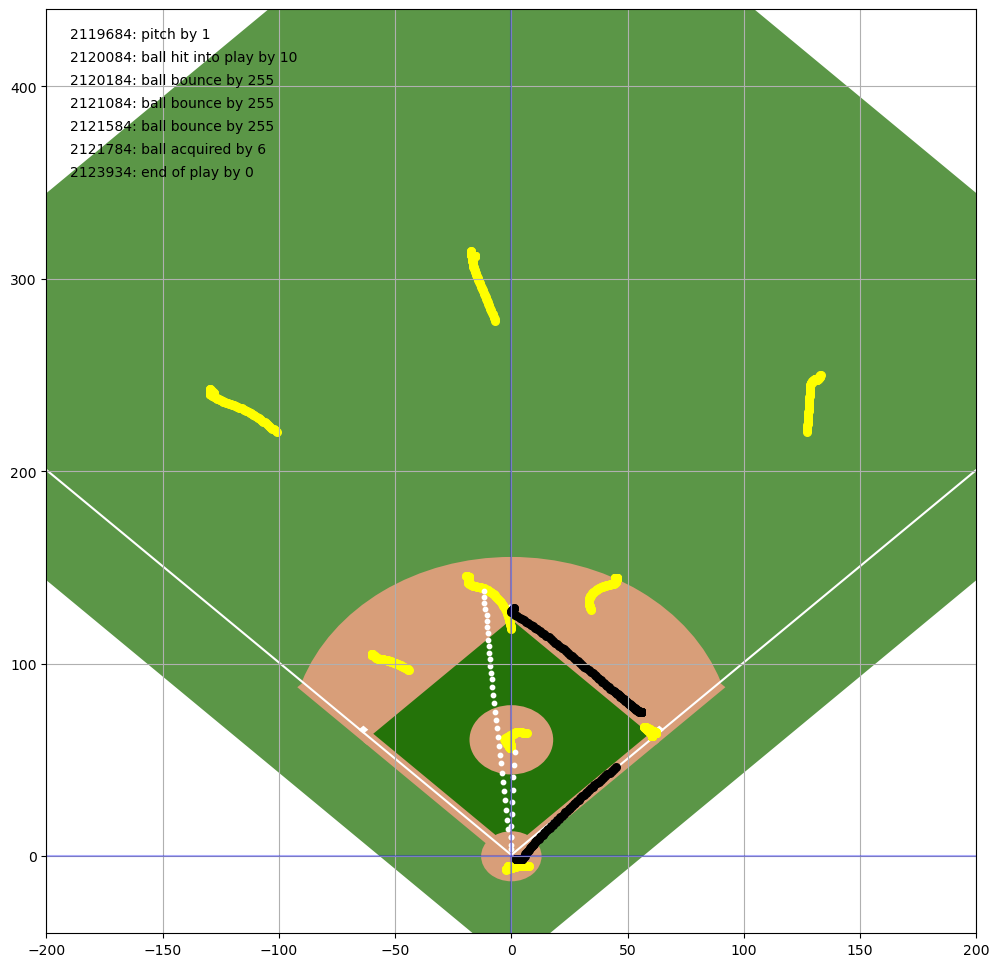

In [17]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(75)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--6_unassisted")

### Bottom of the second

In [18]:

bottom_second = first_two_innings.loc[(first_two_innings["inning"] == 2) & (first_two_innings["top_bottom_inning"] == "Bottom") , :]

outs_seq = bottom_second[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(bottom_second, outs_seq)

print(outs_seq)


[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [19]:
bottom_second.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_second

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
76,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,18,76,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0.0,0.0,0
77,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,19,77,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,2766,0,0,0.0,0.0,1
78,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,19,78,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,2766,0,0,0.0,0.0,1
79,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,20,79,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,1973,2766,0.0,0.0,2
80,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,80,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
81,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,81,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
82,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,82,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
83,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,83,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
84,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,22,84,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,1185,0.0,0.0,2
85,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,22,85,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,1185,0.0,1.0,2


##### Bottom of second description

A description of what is going on rn:

- 76 is a HBP lol that it counts as a ball deflection
- 78 is a double to left field
- 79 is a triple off the right center wall
- 83 is a walk
- 85 is a sac fly to center
- 87 is a 1-3 sacrifice?
- 90 is a lazy fly to left



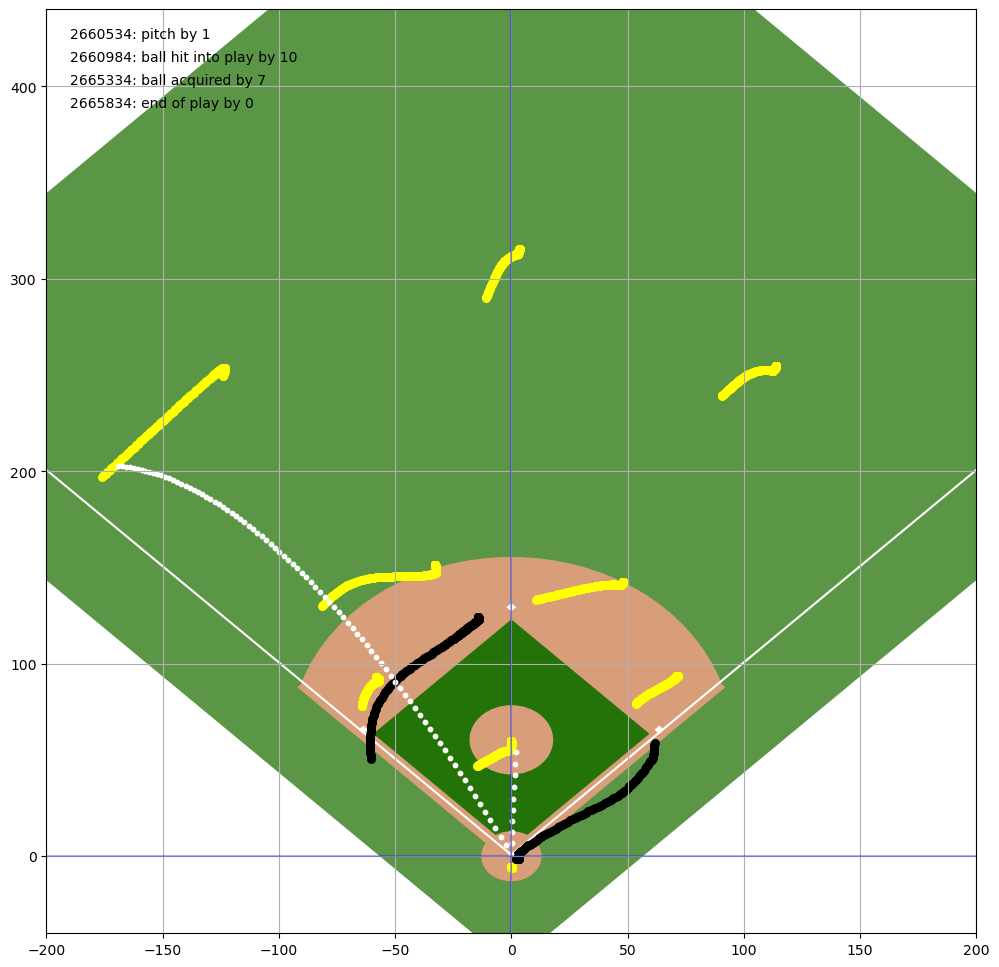

In [20]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(90)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")

### Top of 3

In [28]:

top_three = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 3) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()


top_three["prev_outs"] = np.nan
top_three["this_play_outs"] = np.nan


top_three["n_br"] = top_three[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)



outs_seq = top_three[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_three, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [22]:
top_three.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_three

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
91,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,91,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,NaN,NaN,0
92,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,92,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,NaN,NaN,0
93,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,93,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,NaN,NaN,0
94,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,94,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,NaN,NaN,0
95,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,26,95,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,NaN,NaN,0
96,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,27,96,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,3363,0,0,NaN,NaN,1
97,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,27,97,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,3363,0,0,NaN,NaN,1
98,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,28,98,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,3363,0,0,NaN,NaN,1
99,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,28,99,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,3363,0,0,NaN,NaN,1
100,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,28,100,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,3363,0,0,NaN,NaN,1


#### Where should there be outs:
- 94 must be an out (strikeout)
- what happened on 95? This is a throwing error -- there should not be an out
- 97 (we don't know?) because it isn't there (but one out?)
- 108 is a play at the plate I think no outs
- 109 is a 5-3 put out

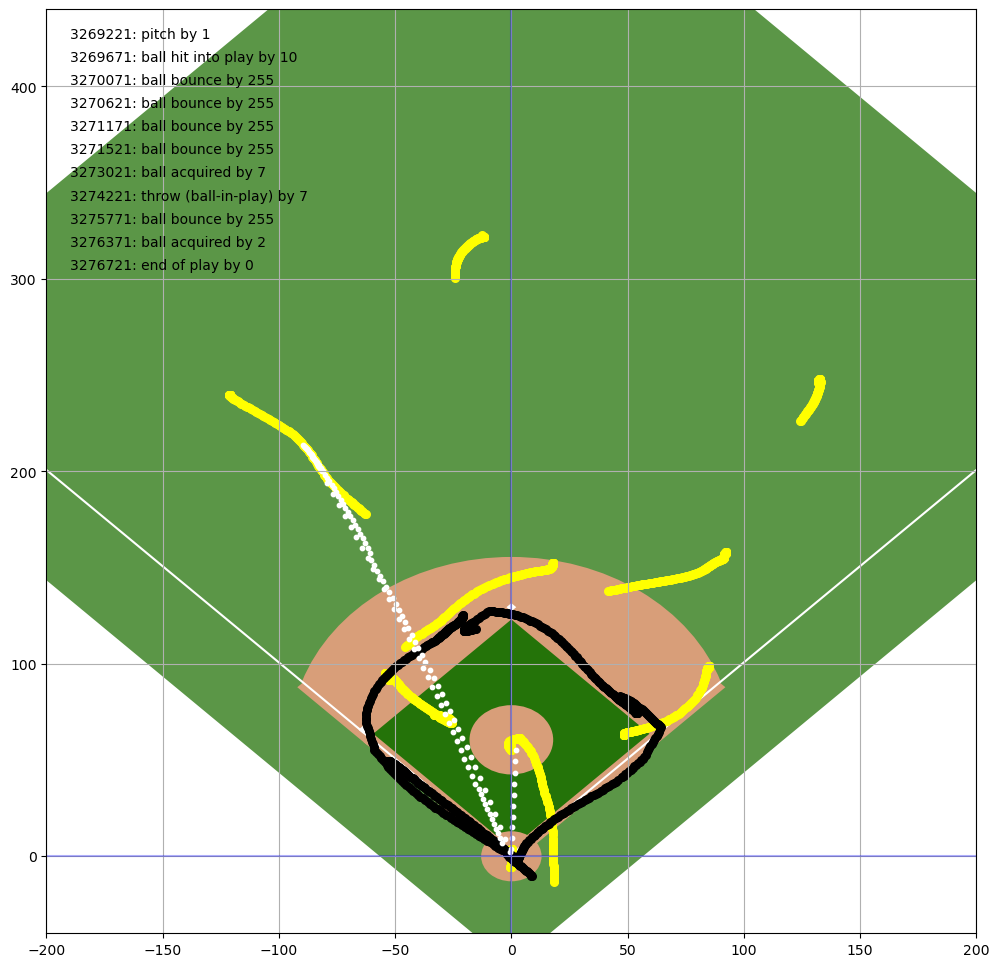

In [35]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(108)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 3

In [ ]:

bottom_three = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 3) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()


bottom_three["prev_outs"] = np.nan
bottom_three["this_play_outs"] = np.nan


bottom_three["n_br"] = bottom_three[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)



outs_seq = bottom_three[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(bottom_three, outs_seq)

print(outs_seq)


In [ ]:
bottom_three.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_three

This is a 1-2-3 inning

### Top 4

In [ ]:

top_four = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 4) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()


top_four["prev_outs"] = np.nan
top_four["this_play_outs"] = np.nan


top_four["n_br"] = top_four[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)



outs_seq = top_four[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_four, outs_seq)

print(outs_seq)


In [ ]:
top_four.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_four

### Bottom 4

In [ ]:

bottom_four = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 4) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()


bottom_four["prev_outs"] = np.nan
bottom_four["this_play_outs"] = np.nan


bottom_four["n_br"] = bottom_four[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)



outs_seq = bottom_four[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(bottom_four, outs_seq)

print(outs_seq)


In [ ]:
bottom_four.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_four

### Top 5

In [ ]:
top_five = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 5) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()


top_five["prev_outs"] = np.nan
top_five["this_play_outs"] = np.nan


top_five["n_br"] = top_five[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_five[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_five, outs_seq)

print(outs_seq)


In [ ]:
top_five.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_five

Another 1-2-3

### Bottom 5

In [29]:
bottom_five = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 5) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()


bottom_five["prev_outs"] = np.nan
bottom_five["this_play_outs"] = np.nan


bottom_five["n_br"] = bottom_five[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_five[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bottom_five, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [16]:
bottom_five.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_five

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
145,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,46,145,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1771,0,0,0,0.0,0.0,0
146,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,46,146,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1771,0,0,0,0.0,0.0,0
147,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,46,147,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1771,0,0,0,0.0,0.0,0
148,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,148,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,0.0,0.0,1
149,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,149,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,0.0,0.0,1
150,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,150,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,0.0,0.0,1
151,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,151,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,0.0,0.0,1
152,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,152,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,0.0,0.0,1
153,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,48,153,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,2148,1286,1771,0,0.0,0.0,2
154,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,48,154,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,2148,1286,1771,0,0.0,0.0,2


#### Where should there be outs:

- 154 could be an out if its a play at the plate -- I think this is not an out
- 159 is a strikeout?
- 160 should have been a fielder's choice!
- 165 is a 6-4 put out


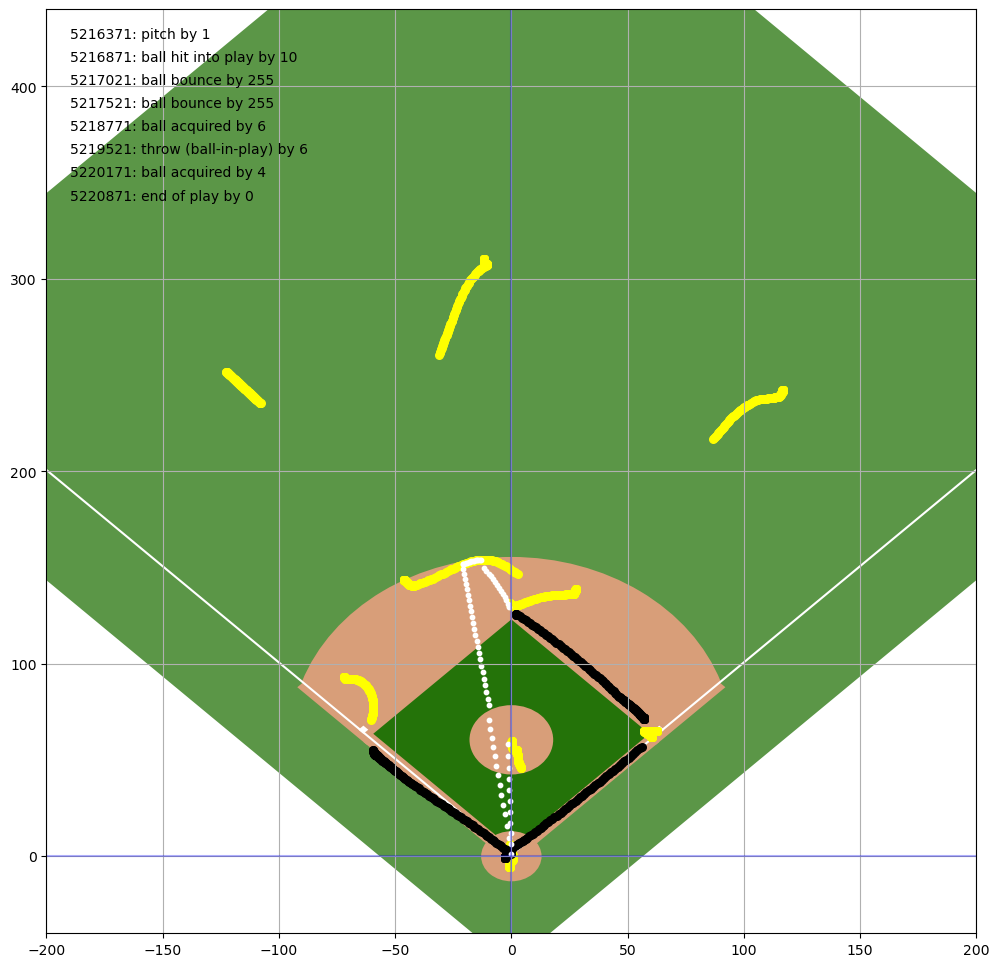

In [17]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(165)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 6

In [36]:
top_six = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 6) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()


top_six["prev_outs"] = np.nan
top_six["this_play_outs"] = np.nan


top_six["n_br"] = top_six[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_six[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_six, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [38]:
top_six.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_six

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
166,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,166,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
167,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,167,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
168,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,168,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
169,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,169,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
170,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,170,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
171,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,53,171,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,5291,0,0,0.0,1.0,1
172,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,54,172,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,5291,0,0,1.0,0.0,1
173,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,54,173,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,5291,0,0,1.0,0.0,1
174,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,54,174,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,5291,0,0,1.0,0.0,1
175,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,55,175,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6789,0,8079,5291,1.0,0.0,2


#### Where should there be outs:

- 171 is a popup
- 176 is proabably a wild pitch and a score -- lol
- 178 is a RBI sacrifice of some kind (6-3 RBI groundout)
- 182 is a strikeout


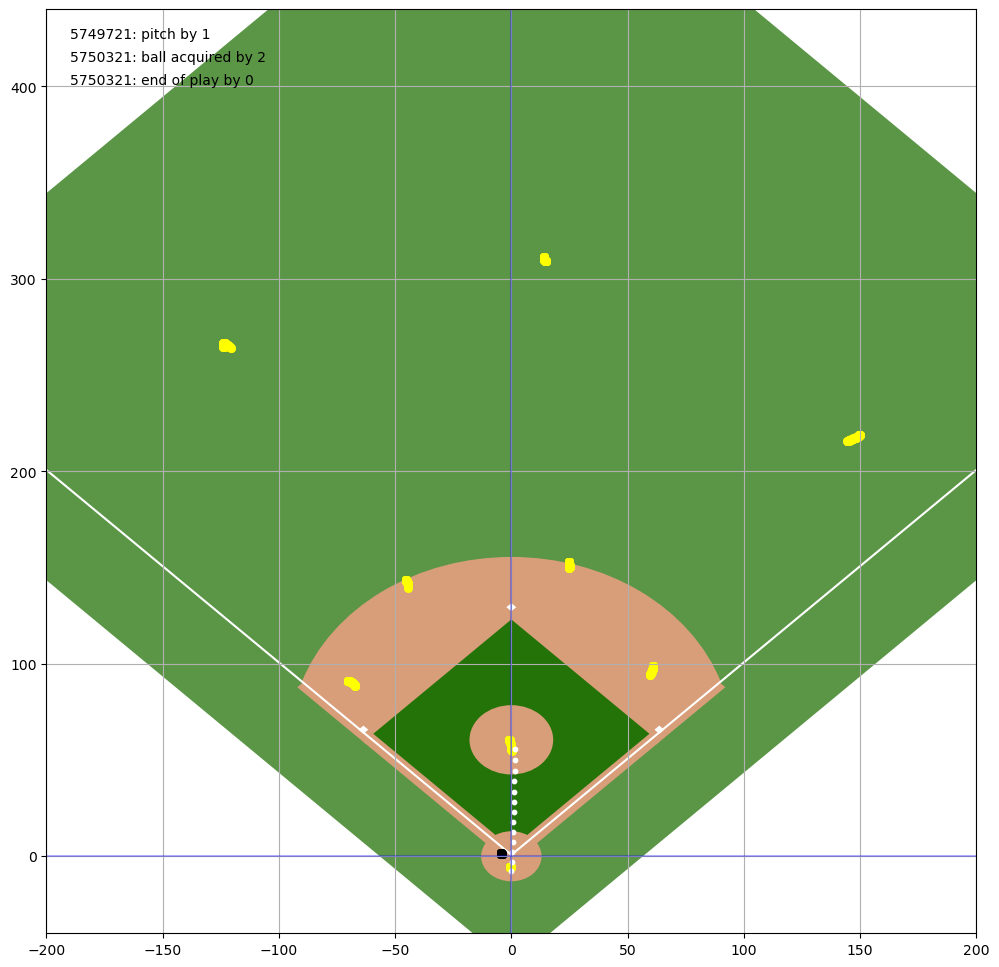

In [42]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(182)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom of 6

In [43]:
bottom_six = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 6) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()


bottom_six["prev_outs"] = np.nan
bottom_six["this_play_outs"] = np.nan


bottom_six["n_br"] = bottom_six[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_six[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bottom_six, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 2.]]


In [44]:
bottom_six.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_six

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
183,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,57,183,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0.0,0.0,0
184,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,184,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,0.0,0.0,1
185,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,185,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,0.0,0.0,1
186,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,186,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,0.0,0.0,1
187,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,187,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,0.0,0.0,1
188,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,188,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,0.0,0.0,1
189,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,189,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,0.0,0.0,1
190,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,190,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,0.0,0.0,1
191,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,191,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,0.0,0.0,1
192,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,192,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,0.0,0.0,1


#### Where should there be outs:


- 187 is a steal?

- TODO: Bring this one up!!! 
    - 198 looks just like a pitch catch? but the third br disappears?
    
- 200 is a strikeout
- 202 is just a flyout -- maybe make a new rule for this one? (e.g. fly ball rule!)



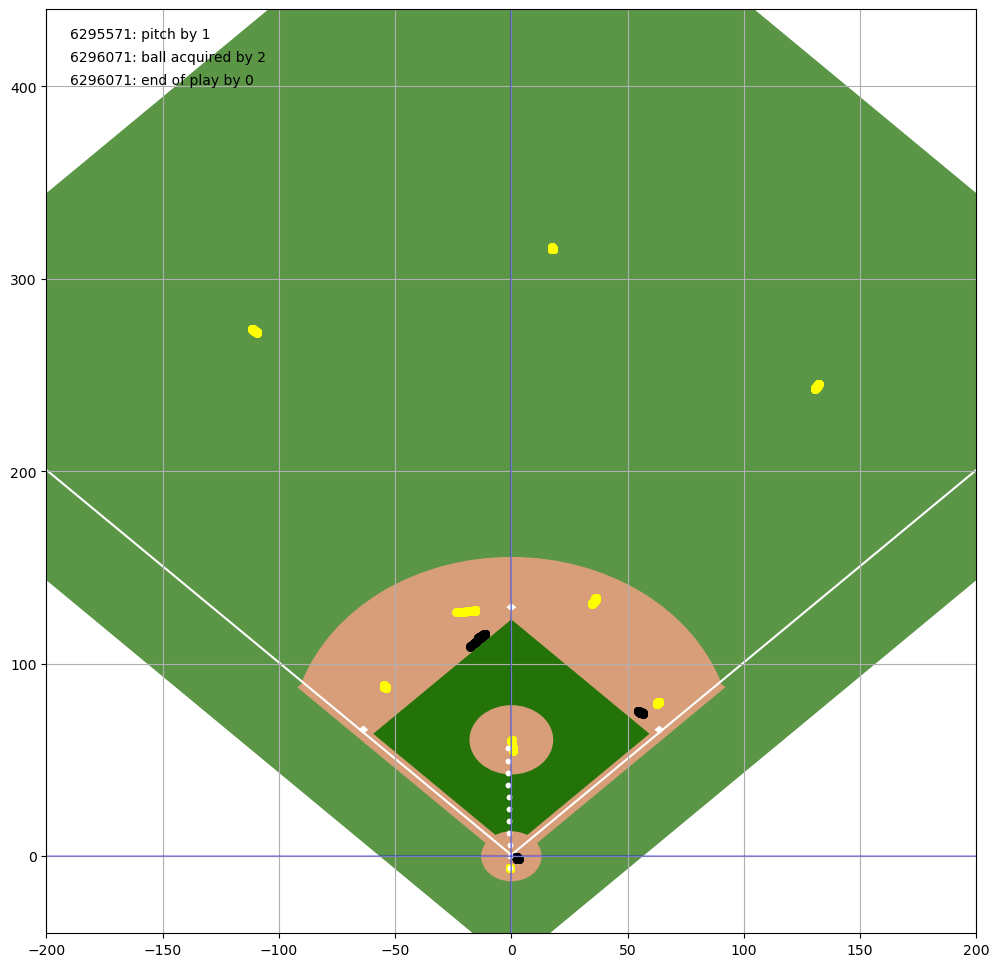

In [53]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(197)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 7

In [54]:
top_seven = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 7) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()


top_seven["prev_outs"] = np.nan
top_seven["this_play_outs"] = np.nan


top_seven["n_br"] = top_seven[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_seven[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_seven, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [55]:
top_seven.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_seven

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
203,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,203,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0.0,0.0,0
204,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,204,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0.0,0.0,0
205,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,205,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0.0,0.0,0
206,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,206,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0.0,1.0,0
207,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,207,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,1.0,0.0,0
208,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,208,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,1.0,0.0,0
209,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,209,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,1.0,0.0,0
210,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,210,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,1.0,0.0,0
211,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,211,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,1.0,1.0,0
212,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,65,212,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,2.0,0.0,0


#### This is a 1-2-3 inning

### Bottom 7

In [56]:
bottom_seven = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 7) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()


bottom_seven["prev_outs"] = np.nan
bottom_seven["this_play_outs"] = np.nan


bottom_seven["n_br"] = bottom_seven[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_seven[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bottom_seven, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [58]:
bottom_seven.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_seven

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
216,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,216,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
217,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,217,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
218,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,218,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
219,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,219,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,1.0,0
220,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,220,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,1.0,0.0,0
221,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,221,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,1.0,0.0,0
222,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,222,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,1.0,0.0,0
223,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,223,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,1.0,1.0,0
224,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,68,224,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,1973,0,0,0,2.0,0.0,0
225,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,68,225,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,1973,0,0,0,2.0,0.0,0


#### This is a 1-2-3 inning

### Top of 8 is not working?

In [59]:
top_eight = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 8) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_eight["prev_outs"] = np.nan
top_eight["this_play_outs"] = np.nan

top_eight["n_br"] = top_eight[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_eight[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_eight, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [60]:
top_eight.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_eight

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
228,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,69,228,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0.0,0.0,0
229,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,69,229,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0.0,0.0,0
230,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,69,230,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0.0,0.0,0
231,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,231,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,0.0,0.0,1
232,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,232,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,0.0,0.0,1
233,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,233,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,0.0,0.0,1
234,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,234,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,0.0,1.0,1
235,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,71,235,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,3718,0,1.0,0.0,1
236,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,71,236,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,3718,0,1.0,0.0,1
237,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,72,237,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,8079,0,0,0,1.0,0.0,0


#### Where should there be outs:

- 234 is 4-3, runner advances
- 249 is a strikeout
- 256 must be another strikeout



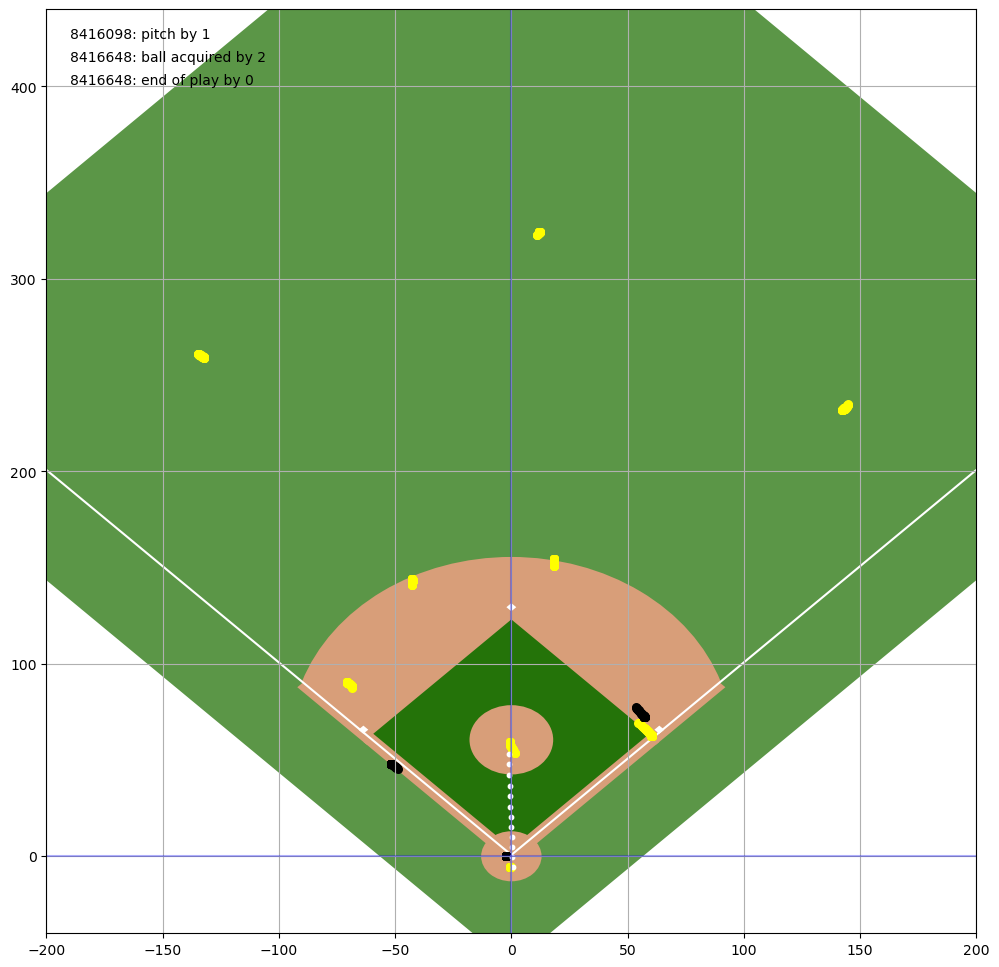

In [64]:
# it thinks that 236 should be an out! I think it should be a HR?

bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(256)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


### Bottom 8

In [65]:
bottom_eight = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 8) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_eight["prev_outs"] = np.nan
bottom_eight["this_play_outs"] = np.nan

bottom_eight["n_br"] = bottom_eight[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_eight[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(bottom_eight, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [66]:
bottom_eight.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_eight

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
257,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,257,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0.0,0.0,0
258,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,258,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0.0,0.0,0
259,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,259,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0.0,0.0,0
260,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,260,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0.0,1.0,0
261,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,77,261,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,1.0,0.0,0
262,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,77,262,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,1.0,0.0,0
263,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,77,263,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,1.0,1.0,0
264,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,78,264,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,2386,0,0,0,2.0,0.0,0
265,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,78,265,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,2386,0,0,0,2.0,0.0,0
266,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,78,266,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,2386,0,0,0,2.0,0.0,0


#### A 1-2-3 inning

### Top 9

In [67]:
top_nine = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 9) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_nine["prev_outs"] = np.nan
top_nine["this_play_outs"] = np.nan

top_nine["n_br"] = top_nine[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_nine[["prev_outs", "this_play_outs"]].copy().values

outs_seq[0, 0] = 0

solve_outs_sequence_seq(top_nine, outs_seq)

print(outs_seq)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 1.]]


In [68]:
top_nine.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_nine

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
268,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,268,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
269,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,269,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
270,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,270,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
271,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,271,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,1.0,0
272,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,272,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
273,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,273,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
274,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,274,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
275,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,275,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,1.0,0
276,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,81,276,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,1.0,0


#### A 1-2-3 inning

## Turn this into a function, then integrate with Game

In [ ]:
def get_play_id_and_ppg_for_event(df, event):
    """
    takes in a game_events_df
    
    event is "home run", etc
    
    """
    
    
    event_indices = df["event"] == event
    
    return df.loc[hr_indices, ["play_id", "play_per_game"]].drop_duplicates()
    
    

get_play_id_and_ppg_for_event(bf_1903_30.game_obj.game_events_df, "home run")
    


In [31]:
full_game = bf_1903_30.game_obj.game_info_df.copy()

full_game["prev_outs"] = np.nan
full_game["this_play_outs"] = np.nan


full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)


# the number of outs but be the same as before
hr_indices = bf_1903_30.game_obj.game_events_df["event"] == "home run"


# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

full_game.loc[switiching_sides_indices, "prev_outs"] = 0


In [32]:

# make an array to store all of these
running_outs_seq = np.full((full_game.shape[0], 2), -99)

running_index = 0

for inning in range(1, 10):
    print(inning)
    
    for which_half in ["Top", "Bottom"]:
    
        print(which_half)
        
        this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]
        
        
        if this_half.shape[0] == 0:
            print("no data for the {} of {}".format(which_half, inning))
            
            # TODO: this means that the home team def won -- maybe track this
            continue
            
        outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
        print(outs_seq.shape)
            
        solve_outs_sequence_seq(this_half, outs_seq)

        # the total number of outs made in a half inning must be 3
        assert sum(outs_seq[:, 1]) == 3
        
        # fill in this sequence into the array
        running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq
        
        running_index += outs_seq.shape[0]


# assign the array back to those cols in the df
full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


1
Top
(11, 2)
Bottom
(45, 2)
2
Top
(19, 2)
Bottom
(15, 2)
3
Top
(19, 2)
Bottom
(12, 2)
4
Top
(10, 2)
Bottom
(6, 2)
5
Top
(7, 2)
Bottom
(21, 2)
6
Top
(17, 2)
Bottom
(20, 2)
7
Top
(13, 2)
Bottom
(12, 2)
8
Top
(29, 2)
Bottom
(11, 2)
9
Top
(9, 2)
Bottom
no data for the Bottom of 9


/var/folders/dq/wt5yn10s5hz3w18xwlm2kvqw0000gn/T/ipykernel_38524/2781902194.py:38: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


## Gut Checks



In [33]:
# there should never be more than 3 outs in either column
full_game[["prev_outs", "this_play_outs"]].describe()

,prev_outs,this_play_outs
count,276.000000,276.000000
mean,0.880435,0.184783
std,0.820320,0.398068
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,2.000000,2.000000


### Are all of the things that have two outs obvious double plays?

In [34]:
full_game.loc[full_game["this_play_outs"] == 2, :]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
202,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,62,202,6,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2148,2386,1945,0,1,2,2


In [ ]:
full_game.loc[full_game["inning"] == 5, :]

In [ ]:
# if a batter is on base, 

# if there is a guy on third that was on second and the guy on first is missing





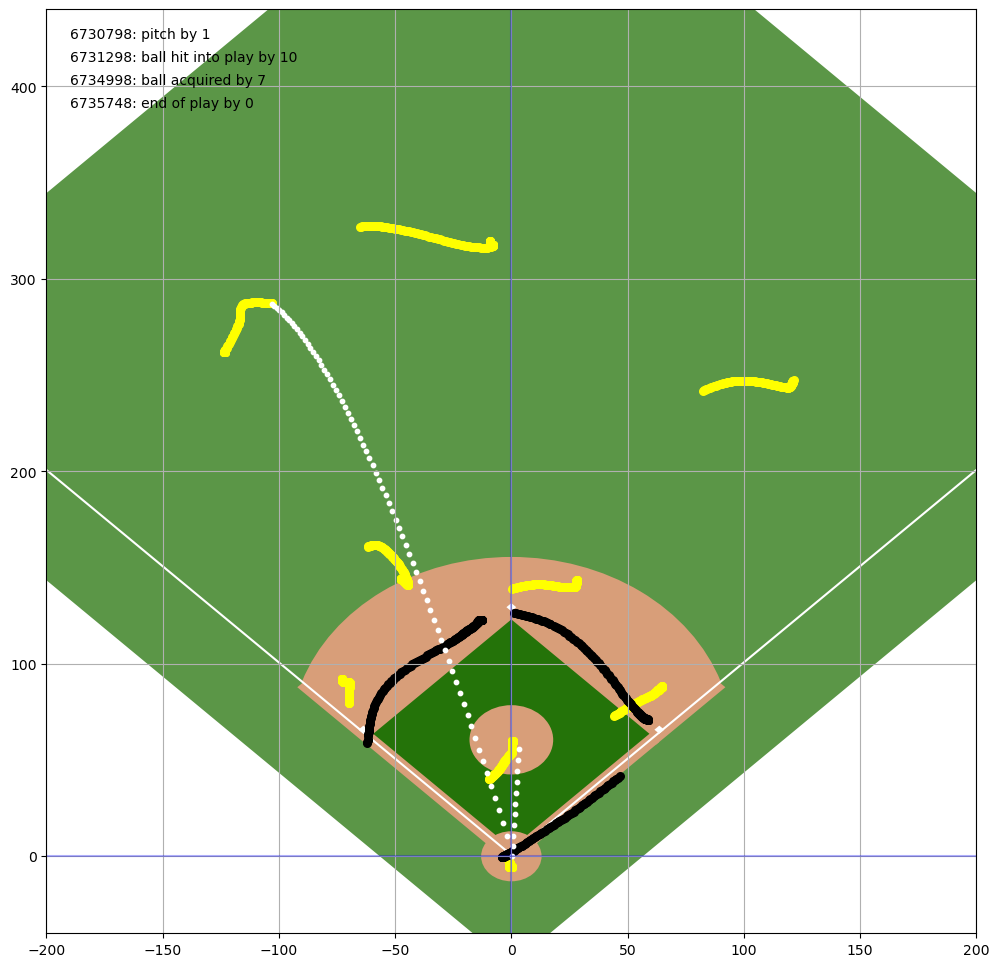

In [35]:
# it thinks that 236 should be an out! I think it should be a HR?

bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(202)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


In [ ]:
running_outs_seq[9:9+outs_seq.shape[0], :] = outs_seq

In [ ]:
running_outs_seq.shape

In [ ]:
### Top of 5

### TODO Still
 
- Make this as module in Game class
- Add a tiny score bug? or like a number of outs bug to plot? Maybe next time I go under the hood there
